In [10]:
#-*- coding: utf-8 -*-
import pandas as pd
import re
import jieba.posseg as psg
import numpy as np

In [11]:
#一.评论预处理
#1.评论去重
reviews = pd.read_csv("data/reviews.csv", encoding='gbk')
#如果UTF-8编码无法解决问题，可以尝试其他编码格式，如'gbk'或'latin-1'等。根据你的文本数据的实际编码情况，尝试使用不同的编码格式进行读取。
reviews = reviews[['content','content_type']].drop_duplicates()
content = reviews['content']

In [12]:
#2.数据清洗

strinfo = re.compile('[0-9a-zA-Z]|京东|美的|电热水器|热水器|')
content = content.apply(lambda x: strinfo.sub('', x))

In [13]:
#二.评论分词
#分词，词性标注，去除停用词代码
#分词
worker = lambda s: [(x.word,x.flag) for x in psg.cut(s)] #自定义简单分词函数
seg_word = content.apply(worker)


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\20887\AppData\Local\Temp\jieba.cache
Loading model cost 0.516 seconds.
Prefix dict has been built successfully.


In [14]:
#将词语转为数据框形式，一列是词，一列是词语所在的句子id，最后一列是词语在该句子中的位置
n_word = seg_word.apply(lambda x:len(x)) #每一评论中词的个数
n_content = [[x+1]*y for x,y in zip(list(seg_word.index),list(n_word))]
index_content = sum(n_content,[]) #将嵌套的列表展开，作为词所在评论的id

seg_word = sum(seg_word,[])
word = [x[0] for x in seg_word] #词
nature = [x[1] for x in seg_word] #词性

content_type = [[x]*y for x,y in zip(list(reviews['content_type']),
                                     list(n_word))]
content_type = sum(content_type,[]) #评论类型

result = pd.DataFrame({"index_content":index_content,
                       "word":word,
                       "nature":nature,
                       "content_type":content_type})

In [15]:
#删除标点符号
result = result[result['nature'] != 'x'] #x为标点符号

In [16]:
#删除停用词
stop_path = open("../code01/data/stoplist.txt", 'r', encoding='utf-8')
stop = stop_path.readlines()
stop = [x.replace('\n','') for x in stop]
word = list(set(word)-set(stop))
result = result[result['word'].isin(word)]

In [17]:
#构造各词在对应评论的位置列
n_word = list(result.groupby(by = ['index_content'])['index_content'].count())
index_word = [list(np.arange(0,y)) for y in n_word]
index_word = sum(index_word,[]) #表示词语在该评论中的位置

In [18]:
#合并评论id，评论中词的id，词，词性，评论类型
result['index_word'] = index_word

In [19]:
#提取含有名词的评论

# 提取含有名词类的评论
ind = result[['n' in x for x in result['nature']]]['index_content'].unique()
result = result[[x in ind for x in result['index_content']]]


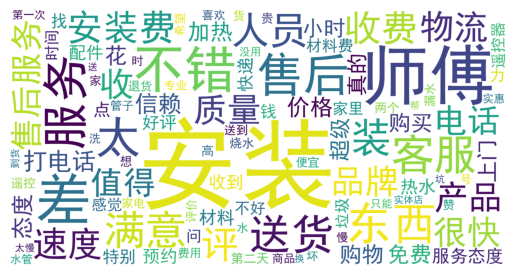

In [24]:
#绘制词云

import matplotlib.pyplot as plt
from wordcloud import WordCloud

frequencies = result.groupby(by = ['word'])['word'].count()
frequencies = frequencies.sort_values(ascending = False)
backgroud_Image=plt.imread('data/p1.jpg')
wordcloud = WordCloud(font_path="simhei.ttf",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
my_wordcloud = wordcloud.fit_words(frequencies)
plt.imshow(my_wordcloud)
plt.axis('off') 
plt.show()

In [25]:
# 将结果写出
result.to_csv("data/word.csv", index = False, encoding = 'utf-8')